# Homework 3

### CS328 — Numerical Methods for Visual Computing and Machine Learning
- - -

**Out** on Thursday 28/10/2021, **due** on Thursday 18/11/2021

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please complete/extend this notebook for your homework submission:

* In addition to your code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.
* Before handing in, please make sure that your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.anaconda.com/products/individual">Anaconda</a>, specifically the version based on Python 3.8.
<br><div class="alert alert-warning">
Please keep in mind that homework assignments must be done individually.
</div>

## Problem -1: Warmup (not graded)
$$
\newcommand{\vp}{\mathbf{p}}
\newcommand{\vl}{\mathbf{l}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\mA}{\mathbf{A}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vc}{\mathbf{c}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\mA}{\mathbf{A}}
\newcommand{\mL}{\mathbf{L}}
\newcommand{\mU}{\mathbf{U}}
\newcommand{\mV}{\mathbf{V}}
\newcommand{\mP}{\mathbf{P}}
\newcommand{\mI}{\mathbf{I}}
$$

The following review and paper & pencil questions are meant to check your comprehension of lecture and reading material in addition to linear algebra prerequisites.

1. In class, we discussed the *power* and *inverse iteration*, which were two algorithms that converge against the largest and the smallest-magnitude eigenvectors of a matrix $\mA$, respectively. Suppose now that we want to develop a new algorithm that finds a different eigenvector $\vv$ whose associated eigenvalue $\lambda\in\mathbb{R}$ is *known* (although it is not necessarily the smallest or largest one).

   The way to do this is to run power iteration on a different matrix $\mA'$ derived from $\mA$, where $\vv$ is now associated with the largest eigenvalue. How can such a matrix be created? It may be helpful to review the definition of eigenvalues in terms of roots of the characteristic polynomial.<br><br>

2. List two ways in which the power iteration can fail to converge.<br><br>

3. Consider a column vector as a $n\times 1$ matrix and write down its singular value decomposition $\mathbf{U\Sigma V}^T$ without using a computer. Do the same exercise once more for a row vector.<br><br>

4. During lecture, we discussed how very ill-conditioned linear systems can be regularized by truncating the associated singular value decomposition (Problem 2 in this homework uses this technique). This effectively corresponds to solving a modified linear system -- can you say something about its condition number?

## 0 Prelude

As in the previous assignments we'll begin by importing essential NumPy/SciPy/Matplotlib components that are needed to complete the exercises. The first two lines instruct Matplotlib to embed figures directly into the notebook and render them in sufficient quality for modern high-DPI ("retina") displays.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import scipy.linalg as la
import scipy.ndimage
from matplotlib import pyplot as plt

The two lines below adjust the default figure size and ensure that low resolution images are rendered with sharp pixel contours instead of a blurry approximation.

In [2]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'

This assignment entails construction of large numbers of temporary matrices that may eventually exceed the available amount on memory of your computer (if never freed), hence it's useful to be able to force the Python garbage collector to run from time to time.  The line below performs the necessary import so that this can be done via a call to ``gc.collect()``.

In [3]:
import gc

# Problem 1. Analyzing bacterial growth using the matrix exponential & bisection (30 Points)

<img width="400" style="border:2px solid #000" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/21/yped_agar_plate.jpg">

This problem focuses on a classical application of ordinary differential equations to model bacterial growth. Suppose a petri dish contains $x(t)$ bacteria at time $t$. Assuming abundant resources (nutrients, size of petri dish), the cell culture will grow exponentially at a rate of approximately

$$
x'(t) = 0.23\,x(t)
$$

cells per minute. Bacterial infections can pose a grave danger if left untreated—in this exercise, we will try to understand the effect of adding $a$ milligrams of an antibacterial agent (e.g. an antibiotic) to the petri dish.
Suppose that this agent kills bacteria a fixed rate of $10^5$ cells per milligram and per minute. The modified differential equation

$$
x'(t) = 0.23\,x(t) - 10^5\,a,
$$

then models the resulting behavior (until no more bacteria are left, at which point the equation becomes nonsensical as cell counts become negative).

Now suppose that the antibacterial agent is unstable and decays at a rate of $\beta$ milligrams per minute. Then $a$ also becomes a function of time satisfying the differential equation

$$
\begin{align}
x'(t) &= 0.23\,x(t) - 10^5\,a(t),\\
a'(t) &= - \beta\, a(t).
\end{align}
$$

In conjunction with the previous equation, we now have a coupled system of two differential equations that can be solved using the eigendecomposition-based matrix exponential approach discussed in class.

### 1.1 Matrix exponential-based solver (20 points)

**TODO**: define a method ``solve_ode(x0, a0, beta, t)`` that takes the initial values of $x(0)$ and $a(0)$ and the $\beta$ parameter as inputs. Your implementation should use ``la.eig()`` to compute and return the value of $x(t)$ at time ``t``.

<div class="alert alert-info">
We have the following system of homogeneous ODE:
$$
\begin{align}
x'(t) &= 0.23\,x(t) - 10^5\,a(t),\\
a'(t) &= - \beta\, a(t).
\end{align}
$$
Therefore, I introduce a vector
$$ \mathbf{y}(t) = 
\begin{bmatrix}
x(t)\\
a(t)\\
\end{bmatrix}$$
So that the system can be represented as
$$ \mathbf{y'}(t) = 
\begin{bmatrix}
x'(t)\\
a'(t)\\
\end{bmatrix}
= \begin{bmatrix}
0.23\,x(t) - 10^5\,a(t)\\
- \beta\, a(t)\\
\end{bmatrix}
= \begin{bmatrix}
0.23 & -10^5\\
0 & - \beta\\
\end{bmatrix}
\begin{bmatrix}
x(t)\\
a(t)\\
\end{bmatrix}
= \mathbf{A}\,\mathbf{y}(t)$$
where
$$\mathbf{A} = 
\begin{bmatrix}
0.23 & -10^5\\
0 & - \beta\\
\end{bmatrix}
$$
</div>

<div class="alert alert-info">
The solution has the form
$$\mathbf{y}(t) = e^{\mathbf{A}t}\,\mathbf{y}(0)$$
where 
$$e^{\mathbf{A}t} = \mathbf{V}\,e^{\mathbf{\Lambda}t}\,\mathbf{V}^{-1}$$
and
$$e^{\mathbf{\Lambda}t} = 
\begin{pmatrix}
e^{\lambda_1t} &  &  \\
& \ddots &  \\
&  & e^{\lambda_nt}  \\
\end{pmatrix},$$
<br>
<center>$\mathbf{V}$ - matrix of eigenvectors</center>
<center>$\lambda_1, \lambda_2 ... \lambda_n$ - eigenvalues</center> 
</div>

In [4]:
# Returns the value of x(t) at time t
def solve_ode(x0, a0, beta, t):
    A = np.array([[0.23, -10 ** 5], [0, -beta]])
    y0 = np.array([x0, a0])
    eig_val, eig_vec = la.eig(A)
    exp_At = eig_vec @ np.diag(np.exp(eig_val * t)) @ np.linalg.inv(eig_vec)
    
    return np.real(exp_At @ y0)[0]

### 1.2 Visualizing the cell counts with $a(0)=2.5mg$ (5 points)

**TODO**: Generate a (sufficiently fine) semi-logarithmic plot (``plt.semilogy()``) that shows the cell counts during the first hour assuming that $x(0)=10^6, a(0) = 2.5 mg$, and $\beta=0.05$. Describe the observed behavior.

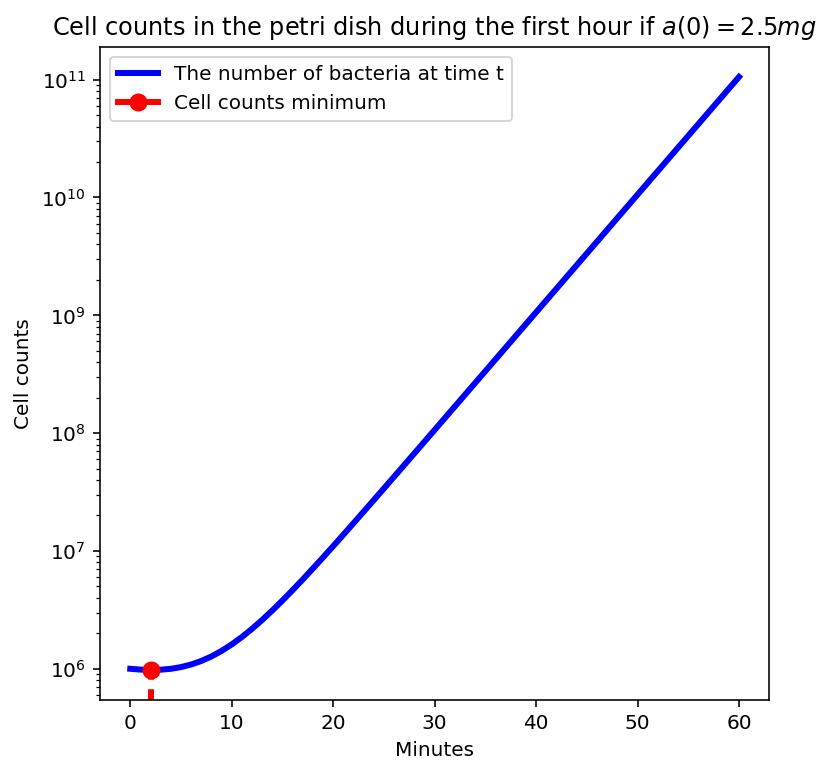

In [5]:
x0 = 10 ** 6
a0 = 2.5
beta = 0.05

hour = np.linspace(0, 60, 61)
cell_counts = np.array([solve_ode(x0, a0, beta, minute) for minute in hour])

plt.semilogy(hour, cell_counts, color = 'blue', linewidth = 3, label = 'The number of bacteria at time t')
plt.plot([np.argmin(cell_counts), np.argmin(cell_counts)], [0, np.min(cell_counts)], color = 'red', linewidth = 3, linestyle = '--')
plt.plot([np.argmin(cell_counts)], [np.min(cell_counts)], color = 'red', linewidth = 3, marker = 'o', markerfacecolor = 'red', markersize = 8, label = 'Cell counts minimum')
plt.xlabel('Minutes')
plt.ylabel('Cell counts')
plt.title('Cell counts in the petri dish during the first hour if $a(0)=2.5mg$')
plt.legend()
plt.show()

<div class="alert alert-info">
We observe that in the case of initial condition $a(0)=2.5mg$ after an antibacterial agent has been added, the number of bacteria in a petri dish started decreasing. However, after <b>$\approx 2$ minutes</b> as the antibacterial agent decays, the cell counts increase monotonically exponentially.
</div>

### 1.3 Visualizing the cell counts with $a(0)=3mg$  (5 points)

**TODO**: Now generate the same plot, but with initial condition $a(0)=3mg$. What do you observe?

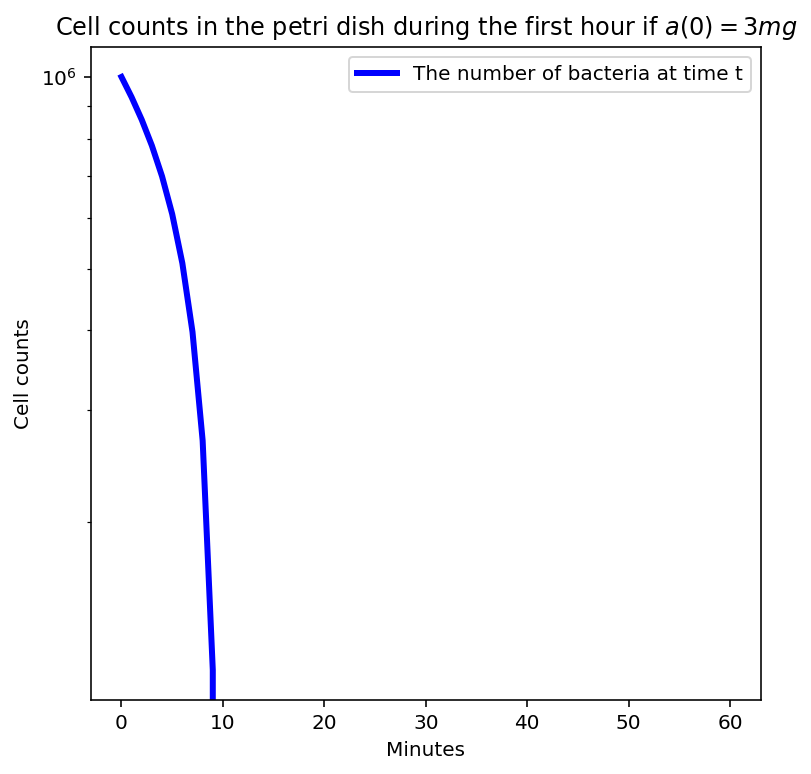

In [6]:
x0 = 10 ** 6
a0 = 3
beta = 0.05

hour = np.linspace(0, 60, 61)
cell_counts = np.array([solve_ode(x0, a0, beta, minute) for minute in hour])

plt.semilogy(hour, cell_counts, color = 'blue', linewidth = 3, label = 'The number of bacteria at time t')
plt.xlabel('Minutes')
plt.ylabel('Cell counts')
plt.title('Cell counts in the petri dish during the first hour if $a(0)=3mg$')
plt.legend()
plt.show()

<div class="alert alert-info">
We observe that in the case of initial condition $a(0)=3mg$ after an antibacterial agent has been added, the number of bacteria in a petri dish started decreasing and then continued decreasing exponentially while the antibacterial agent was decaying.
</div>

### 1.4 Optional Exercise  (0 pts, not graded)

**TODO (Optional)**: Suppose we want to find just the right amount of antibiotic that will extinguish all bacteria over the course of an hour until finally $x(60)=0$. This is a nonlinear problem. Use the bisection algorithm discussed in class to find the necessary value of $a(0)$ and generate another semi-logarithmic plot that visualizes the resulting bacteria counts during the first hour.

In [7]:
# TODO (Optional)

# Problem 2. The Shadow Box and the SVD-powered X-Ray Glasses (70 points)
#### Based on an assignment by Doug James

In this assignment, you will learn how to “see through paper” to analyze the contents of a mysterious shadow box. 
The *shadow box* is a cube containing a light source and an occluder casting a shadow onto a paper screen that is visible from the outside. The following image illustrates the concept:

<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-02.jpg">

The specific problem you'll solve is to *infer* the shape of a mystery light source by looking at the shadow it casts. This seems impossible!

“How can this incredible power become mine,” you ask? The answer is that you will learn how to use the method of Regularized Least Squares and the too-good-to-be-true Singular Value Decomposition (SVD) to invert the nearly singular light transport process. Mathematically, you will solve $\mA\vx = \vb$ problems with rank-deficient $\mA$ matrices, where the $\vx$ and $\vb$ vectors represent the light source and shadow images, respectively.

We'll first focus on the principles of light and shadows that are needed to implement a physically realistic simulation of the shadow box using NumPy and will refer to this as the *forward problem*.  Once the implementation of the forward problem works as expected, you'll be able to move onto the more interesting *inverse problem*: recovering the light source for a given shadow.

### Preliminaries

In this exercise, all light sources, blockers, and shadow images are represented as $200\times 200$ images. Begin by downloading the file <a href="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/22/images_v2.npz">images_v2.npz</a>, which contains a number of these images needed to complete the exercise. Place the file into the directory containing the current notebook and then execute the following fragment:

In [8]:
# All images have resolution 200x200 pixels, save this in 'n' for convenience
n = 200

# Load a number of images the NPZ file, we'll use them shortly
with np.load("images_v2.npz") as npzfile:
    images = dict(npzfile)    
    # View names of loaded images
    print(images.keys())

dict_keys(['debug1', 'debug2', 'decoupage', 'epfl', 'fluorescent', 'hand', 'paper', 'qmark', 'shadow1', 'shadow2', 'shadow3', 'shadow4', 'shadow5'])


The ``images`` map contains both grayscale and RGB images. The former are encoded as standard double precision NumPy matrices (see the left subfigure), with rows of the images corresponding to rows of the matrix (side remark: this means that pixels are indexed using the notation ``image[y, x]`` instead of ``image[x, y]``). Images with RGB color data are stored as 3-tensors, which are  matrices that simply extend into one additional dimension with exactly 3 entries corresponding to the red, green, and blue color channels (right subfigure).
 
<img width="600" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-03.jpg">

We'll use the NumPy *broadcasting* feature to perform arithmetic involving images of different shapes in this assignment. Please review the <a href="https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html">documentation</a> in case you are not familiar with its operation. A brief knowledge check: do you know why the following sequence of statements
```python
test_1 = np.zeros((200, 200))
test_2 = np.zeros((200, 200, 3))

test_1 * test_2
```
fails with an exception, while the following works?
```python
test_1[..., np.newaxis] * test_2
```

As in the previous homework exercise, pixel values are taken to be linear in the amount of light (photons) represented, that is: doubling the value of a pixel should produce twice the brightness when displayed on a screen. An inverse gamma correction must thus be applied to ensure that this is the case given the nonlinear response of current display devices. The function ``show()`` defined below does this and also re-scales images with large pixel values that are greater than ``1.0``. Try running it on some of the images, e.g. ``images['paper']``.

In [9]:
def show(image, *args):
    """
    This function takes an image with linear pixel values and applies
    an inverse gamma correction similar to what was done in homework 2
    before displaying it. The image is also re-scaled based on the
    maximum value and thus doesn't need to be in the range [0, 1].
    """
    img = np.array(image)
    img[img < 0] = 0
    img = 0.9 * img / np.max(img)
    plt.imshow(img ** (1 / 2.2), cmap='gray', *args)

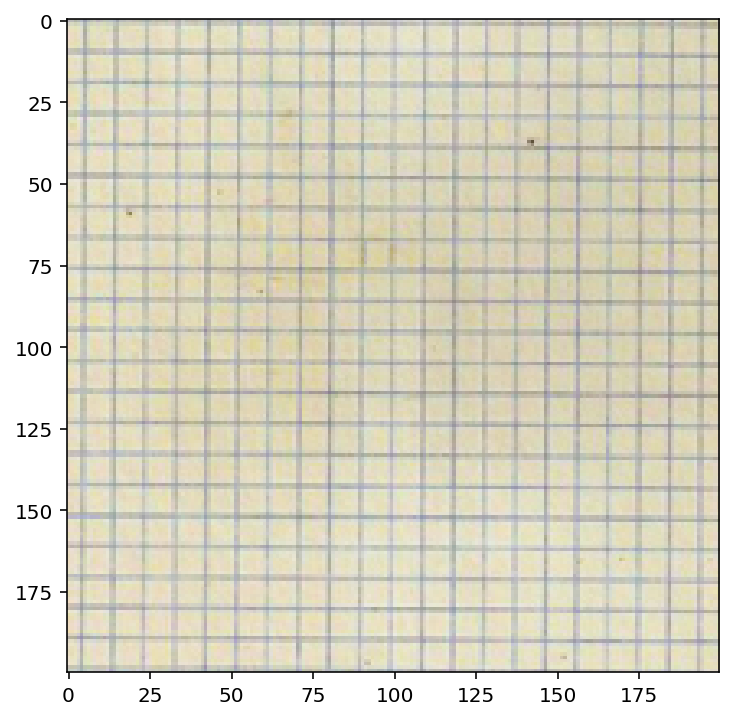

In [10]:
show(images['paper'])

#### Shadow box geometry

A few more specifications before we continue: the shadow box is located inside a symmetric cube of unit length. The distance between the light source and and the blocker is given by the variable $t$, which we (arbitrarily) define as $0.7$.

<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-01_1.jpg">

In [11]:
t = 0.7 # (i.e. closer to the paper)

### Part 1 (the forward problem): computing the shadow for a given light source

Rendering shadow box images with arbitrary light sources may appear like a rather challenging problem. Fortunately, it can be simplified considerably by breaking the process into a few basic steps. First of all, we shall only consider illumination which have a single pixel on the light source "turned on". Note the crisp shadow from such a small light source:

<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-04.jpg">

It turns out that this is really all we need: light is *linear* in the sense that the effects of multiple individual light sources can simply be added up to obtain the total illumination. This means that any more complex light source shape in the shadow box can be recreated by summing the shadow images corresponding a number of separate 1-pixel light sources.

The illumination from a 1-pixel light source is modeled as the product of three terms:

<img width="600" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-06.jpg">

1. **Irradiance**: specifies how much light arrives at the paper assuming that no light is being blocked.<br><br>

2. **Blocker evaluation**: sets pixels to zero that do not receive any light due to the blocker. Which pixels are blocked of course depends on the position of the pixel light source, hence this image differs from the (static) blocker image in the shadow box blueprint shown above.<br><br>

3. **Paper**: This is an RGB image which modulates the previous two components to simulate the effect of a paper texture. The paper image is static and stored in ``images['paper']``.

The following sections focus on computing each of these parts in turn.

### 2.1 Irradiance from a pixel light source while ignoring the blocker (15 points)

We assume that a 1-pixel light source can be approximated as a single point due to its small size, and that it emits $\Phi$ units of energy uniformly into all directions. At a distance of $d$ from the point, that light will have spread out over a concentric sphere with surface area $4\pi d^2$:

<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-05.jpg">

Points on the paper screen obviously receive less illumination the farther they are away from the light source, and in this case the density of light on the sphere will have decreased to a value of $\Phi/(4\pi d^2)$ at distance $d$. This means that to determine the brightness at each point, we must be able to compute how far all the pixels on the paper screen are from the light source pixel.

In addition to this, another effect plays an important role: parts on the paper screen that are illuminated from an oblique angle will be *darker* than parts that are illuminated perpendicularly. This happens since light stretches out over a different amount of surface area in these two cases, which is illustrated by the following drawing:

<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-09.jpg">

More specifically, the amount of reduction is proportional to $\cos\theta$, where $\theta$ is the angle between the surface normal and the line towards the point light source. Combining these two effects, we now can define how much light a point $\vp$ on the paper screen receives  from a light source at position $\vl$ (this is known as the *irradiance*):

$$
E_\vl(\vp) = \frac{\Phi \cos \left(\theta(\vl, \vp)\right)}{4\pi \|\vp-\vl\|^2},
$$

where and $\theta(\vl, \vp)$ is the angle described above. We'll assume that the pixel light source emits unit power, i.e. $\Phi=1$.

**TODO**: Implement the function ``eval_irradiance()`` that evaluates $E_\vl(\vp)$ following the interface shown in the documentation below.

<br>
<div class="alert alert-warning">The irradiance will be evaluated hundreds of millions of times in this exercise (!), hence it is crucial that this is done very efficiently. In particular:<br><br>
1. The function should simultaneously compute the irradiance for all points on the paper screen using vectorization. ``for`` loops and such are forbidden! <br><br> 2. Costly operations like trigonometric function evaluations should be avoided in performance critical code if possible. Recall that most trigonometric functions have a geometric interpretation as certain ratios of edge lengths in triangles. <b>Use this to replace the pesky cosine term with a function of the distance </b>$\|\vp-\vl\|$<br><br> Before continuing, make sure that evaluating your implementation with arguments ``eval_irradiance(0.3, 0.6)`` matches the reference data provided in ``images['debug1']``.
</div>

<div class="alert alert-info">
Since the distance between the paper plane and light plane is equal to 1, we will get the following $L_2$ norm of 3D vector
$$\begin{equation} \label{eq1}
\begin{split}
\|\vp-\vl\| &= \sqrt{(p_x - l_x)^2 + (p_y - l_y)^2 + (p_z - l_z)^2} \\ &= \sqrt{(p_x - l_x)^2 + (p_y - l_y)^2 + (1 - 0)^2}
\end{split}
\end{equation}$$
And the cosine can be calculated as
$$\cos(\theta(\vl, \vp)) = \frac{Adjacent}{Hypotenuse} = \frac{1}{\|\vp-\vl\|}$$
    Therefore, <i>irradiance</i>,  assuming that the pixel light source emits unit power, i.e. $\Phi=1$, will be equal
$$\begin{equation} \label{eq2}
\begin{split}
E_\vl(\vp) &= \frac{\Phi \cos \left(\theta(\vl, \vp)\right)}{4\pi \|\vp-\vl\|^2} &= \frac{1}{4\pi \|\vp-\vl\|^{3}} &= \frac{1}{4\pi \,[(p_x - l_x)^2 + (p_y - l_y)^2 + 1]^{3/2}}
\end{split}
\end{equation}$$
</div>

In [12]:
# Maps from pixel indices to pixel coordinates
grid = np.linspace(0, 1, n)

# 200x200 grid of X and Y positions in the range [0, 1]
X, Y = np.meshgrid(grid, grid)

def eval_irradiance(lx, ly):
    """
    Given a light source position l = [lx, ly], evaluate
    E_l(p) for every position 'p' on the paper screen
    (defined in the two arrays 'X' and 'Y' above) and
    return the result as a 'n' by 'n' matrix.

    Input:
    
       lx, ly:  2D coordinates of the point light source on the light plane
                (both values are in the range [0, 1])
                
    (The reference solution has two lines of code and uses no loops
     or trigonometric functions)
       
    """
    vec_norm = ((X - lx) ** 2 + (Y - ly) ** 2 + 1) ** 0.5
    E = 1 / (4 * np.pi * vec_norm ** 3)
    
    return E

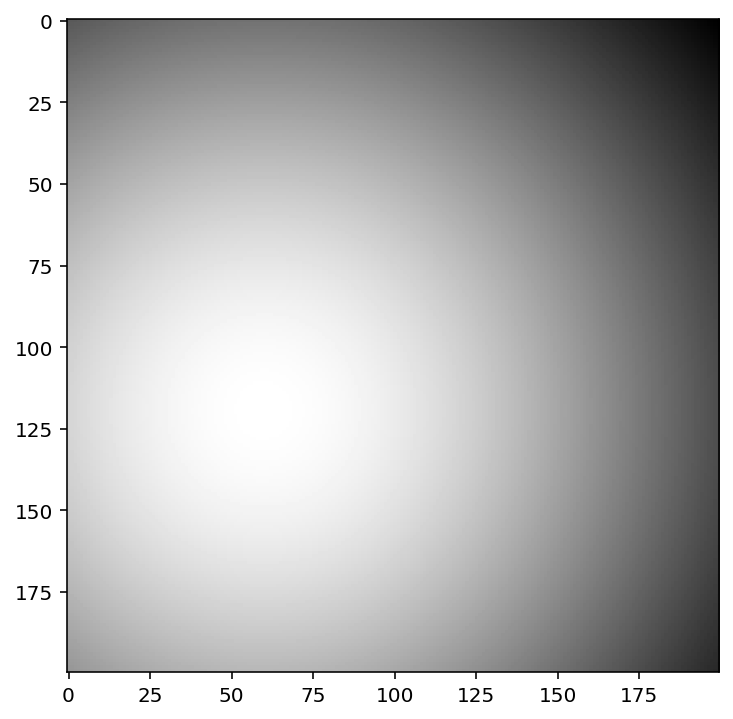

In [13]:
show(eval_irradiance(0.3, 0.6))

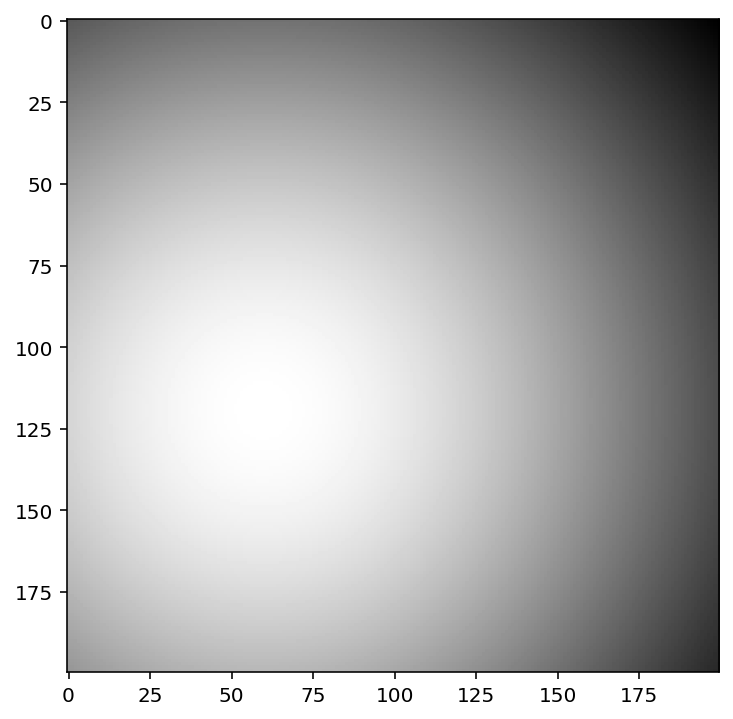

In [14]:
show(images['debug1'])

<div class="alert alert-info">
Let's compute the maximum pixel difference between the result and the debug image:
<div>

In [15]:
diff = np.max(np.abs(eval_irradiance(0.3, 0.6) - images['debug1']))
print(f'The maximum pixel difference between the result and the debug image is {diff}')

The maximum pixel difference between the result and the debug image is 4.163336342344337e-17


### 2.2 Evaluating the blocker (15 points)

Next, we'll evaluate the blocker image to determine which pixels on the paper screen are in shadow. To do this, we need to connect the light source position $\vl$ with every pixel on the paper screen and compute the corresponding intersections with the blocker plane.
<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-10.jpg">

Following this, we can simply look up the value of the blocker image at these intersection points. A resulting value of ``0.0`` indicates a shadow, while ``1.0`` signals that light can pass through undisturbed. One slight issue with the above approach is that the intersection points generally won't be located at integer pixel positions, so we can't use them to index directly into the blocker image array. Fortunately, SciPy provides a helper function ``scipy.ndimage.map_coordinates()`` that can evaluate arrays at intermediate positions while applying interpolation.

**TODO**: Implement the ``eval_blocker()`` function following the specification below. 

<br><div class="alert alert-warning">
Use the ``scipy.ndimage.map_coordinates()`` function with parameter ``order=1`` (for linear interpolation) and vectorization to simultaneously evalute the blocker for all points $\vp$. Don't forget to re-scale the inputs to ``map_coordinates`` so that they lie in the range $[0, n-1]$.<br><br>Before continuing, make sure that evaluating your implementation with arguments ``eval_blocker(images['hand'], 0.3, 0.6)`` matches the reference data provided in ``images['debug2']``.
</div>

<div class="alert alert-info">
According to the Intercept theorem we get:
$$int_x = l_x + t \cdot (p_x - l_x)$$
$$int_y = l_y + t \cdot (p_y - l_y)$$
where $int_x$ and $int_y$ - the coordinates of the intersection points.
</div>

In [16]:
def eval_blocker(blocker, lx, ly):
    """
    Given a light source position l = [lx, ly], evaluate
    the blocker for every position 'p' on the paper screen
    (defined in the two arrays 'X' and 'Y' above) and
    return the result as a 'n' by 'n' matrix.

    Input:
    
       blocker: a 200x200 pixel blocker image
    
       lx, ly:  2D coordinates of the point light source on the light plane
                (both values are in the range [0, 1])
                
    (The reference solution has four lines of code and uses no loops)
    """
    res_x = lx + t * (X - lx)
    res_y = ly + t * (Y - ly)
    res_x_rescale = np.clip(res_x * (n - 1), 0, (n - 1))
    res_y_rescale = np.clip(res_y * (n - 1), 0, (n - 1))
    
    return scipy.ndimage.map_coordinates(blocker, (res_y_rescale, res_x_rescale), order = 1)

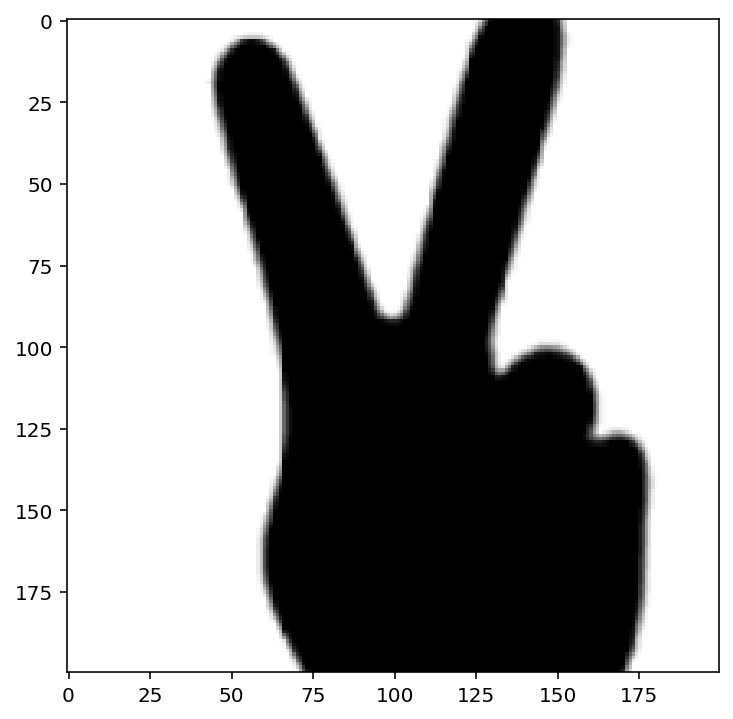

In [17]:
show(eval_blocker(images['hand'], 0.3, 0.6))

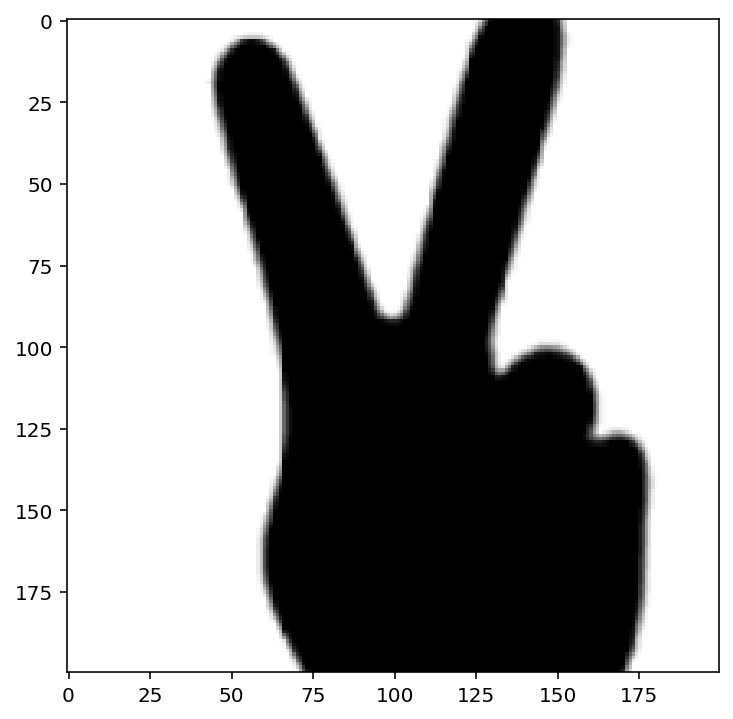

In [18]:
show(images['debug2'])

<div class="alert alert-info">
Let's compute the maximum pixel difference between the result and the debug image:
<div>

In [19]:
diff = np.max(np.abs(eval_blocker(images['hand'], 0.3, 0.6) - images['debug2']))
print(f'The maximum pixel difference between the result and the debug image is {diff}')

The maximum pixel difference between the result and the debug image is 2.55351295663786e-14


### 2.3 Putting everything together (5 points)

**TODO**: Define a function ``render()`` that evaluates the combination of the irradiance, blocker, and paper image as described earlier.

<div class="alert alert-info">
The illumination from a 1-pixel light source is modeled as the product of three terms: irradiance, blocker evaluation and paper image. To multiply each channel of paper image by the product of irradiance and blocker, we should add an additional axis to the product (Broadcasting: when operating on two arrays, NumPy compares their shapes element-wise and two dimensions are compatible when they are equal or one of them is 1).
</div>

In [20]:
def render(blocker, lx, ly):
    """
    Given a light source position l = [lx, ly], compute an
    image that combines the effects of the light source
    irradiance, blocker, and transmission through the paper image.

    Input:
    
       blocker: a 200x200 pixel blocker image
    
       lx, ly:  2D coordinates of the point light source on the light plane
                (both values are in the range [0, 1])
                
    (The reference solution has two lines of code and uses no loops)
    """
    irrad_block = (eval_irradiance(lx, ly) * eval_blocker(blocker, lx, ly))[..., np.newaxis]
    
    return irrad_block * images['paper']

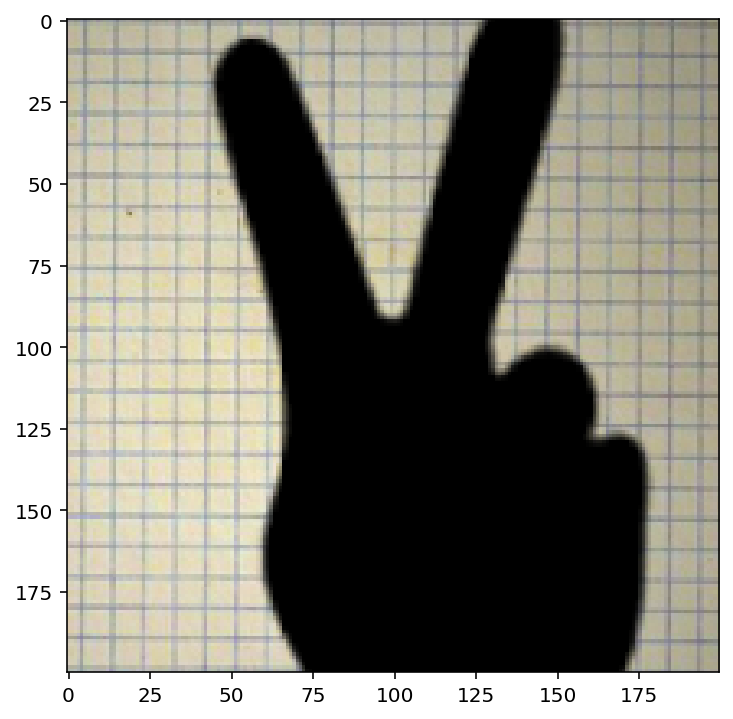

In [21]:
show(render(images['hand'], 0.3, 0.6))

#### The final step: assembling the light box matrix

Given your implementation of the ``render()`` function above, the final step will involve calling it many times for each possible light source pixel. Every invocation will produce an image that is then converted into a single column of a light transport matrix $\mA$ that can be used to describe the behavior of the entire shadow box in terms of a matrix multiplication:
$$
\mA\vx = \vb.
$$
Here, $\mA$ (the *light transport matrix*) models the effects of light falloff and the blocker. $\vx$ is a vector with $200^2$ entries containing the light source intensities, and $\vb$ is the image shown on the paper screen.

However, there is a serious problem with the above approach: a single image returned by ``render()`` has $200\cdot200\cdot 3$ entries–in other words, one column of $\mA$ requires 937 KiB in double precision. There are $200^2$ columns corresponding to all light source pixels, which means that storing the entire matrix $\mA$ would require a whopping 35 GiB of memory! (and this won't be enough, since we will also want to perform singular value decompositions of the resulting data)

To avoid running out of memory, we'll create matrices $\mA$ with many fewer columns that each have entire blocks of light source pixels turned on at the same time. We let $b$ denote the number of blocks along each axis and refer to to the resulting representation as a *light basis* with resolution $b \times b$. The following figure shows an example of a $4\times 4$ light basis.

<img width="800" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-07_1.jpg">

For your convience, we provide a helper function ``render_basis()`` that constructs the matrix $\mA$ while displaying progress messages (this can take several minutes). Reasonable values for $b$ are $10, 20, 25, 40, $ or even $50$. Note that this function assumes that your implementation of ``render()`` is sufficiently vectorizable so that it can be used to compute multiple light source images at once. You may have to fix your implementation for it to work with ``render_basis()`` in case error messages appear when using it.

Don't run this function with very small values of $b$ (e.g. 1) or very large ones (e.g. 200) or you will run out of memory. To release memory from variables that are no longer needed, use the ``del`` command and potentially ``gc.collect()`` to force the garbage collector to run.

In [22]:
def render_basis(blocker, b):
    """
    Convenience function which precomputes the light transport matrix A
    as described above. Expects a blocker image and a number 'b' of light
    transport blocks.
    
    Returns a 120000 x b^2 matrix
    """
    
    # Allocate memory for an uninitialized light transport matrix
    A = np.empty((n*n*3, b**2))
    index = 0
    
    # Iterate over b^2 blocks of (n/b)^2 light source pixels
    blocks = np.array_split(grid, b)
    for by in blocks:
        for bx in blocks:
            # Generate positions of all pixel light sources within the current block 
            BX, BY = np.meshgrid(bx, by)

            # We want to use vectorization to simultaneously render one image for
            # every light pixel within the current block. The following two lines
            # append two extra dimensions that will be used for the pixel coordinates
            # of the output images
            BX = BX[:, :, np.newaxis, np.newaxis]
            BY = BY[:, :, np.newaxis, np.newaxis]
            
            # Sum up all light sources within the block
            tmp = np.sum(render(blocker, BX, BY), axis=(0, 1))

            # Store the resulting image as a column in the resulting matrix
            A[:, index] = tmp.ravel()

            # All of this takes a while, so keep track of progress
            index += 1
            print('\rProgress: %.2f%%' % (100 * index / (b*b)), end='')
            
        # Reclaim unused memory
        gc.collect()
    return A

### Part 2 (the inverse problem): computing the light source corresponding to a particular shadow

Having wrapped up the forward problem, let's now focus on the *inverse problem*: determining the light source shape from a shadow observed on the paper screen. This is a least squares problem: we desire to find the linear combination of light basis vectors that best matches the observed shadow $\vb$. Using higher values of $b$ will lead to finer resolution reconstructions during this process.

Unfortunately, the light transport matrix $\mA$ is much too ill-conditioned to invert directly. Furthermore, matrices created for high resolution light bases tend to have a worse condition numbers than those created for comparatively coarse ones. As we have discussed in the lectures, ill-conditioned matrices tend to magnify the effects of noise and miniscule rounding errors, causing nonsensical solutions containing components with extremely large magnitudes.

To solve the least squares system without these issues, we will apply a *truncated SVD* (TSVD) solver as discussed in class. This entails computing the economy-size SVD (``scipy.linalg.svd`` with parameter ``full_matrices=False``).
Let

$$
\mathbf{U\Sigma V}^T = \mathrm{svd}(\mA),
$$

where the columns of $\mU$ and $\mV$ are denoted as $\vu_i$ and $\vv_i$, respectively, and $\mathbf{\Sigma}$ is a diagonal matrix with entries $\sigma_i$. Then the solution of the linear system $\mA\vx=\vb$ can be expressed as
$$
\vx=\sum_{i=1}^{b^2}\vv_i \frac{1}{\sigma_i} \vu_i^T\vb
$$

The idea of the truncated SVD solver is to restrict the summation to singular values satisfying $\sigma_i > \sigma_0\cdot \varepsilon$ for some given value of $\epsilon \ll 1$, which avoids dividing by very small values of $\sigma_i$.

### 2.4 TSVD Solver (15 points)

**TODO**: Create a function that realizes the TSVD solver described above. Since the function will be called many times with different settings, it's probably a good idea to design it in a way so that it takes a **precomputed singular value decomposition and $\epsilon$ as parameters**. One remark: note that the SciPy implementation of
```python
U, S, Vt = la.svd(A)
```
returns the ``Vt`` matrix already in transposed form.

<div class="alert alert-info">
According to the task, I have written a TSVD solver that takes precomputed singular value decomposition and $\epsilon$ as parameters assuming that "Vt" is already in transposed form.
</div>

In [23]:
# TODO (the solution has 7 lines of code and uses a loop)
def TSVD_solver(U, S, Vt, b, eps = 0.005):
    x = np.zeros(Vt.shape[1])
    for i in range(len(S)):
        if S[i] > S[0] * eps:
            x += (1 / S[i]) * np.outer(Vt[i, :], U[:, i]) @ b
        else:
            break
    
    return x

## The challenges (20 points)

The following image shows a number of challenges for you to solve. The shown names correspond to named entries in the ``images`` dictionary.

<img width="1000" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2016/11/20/shadowbox-08.jpg">


**TODO**: Begin with the first challenge (second column) and perform the following steps:

1. (4 pts) Generate a $20\times 20$ or $40 \times 40$ light basis for the ``hand`` blocker and compute its SVD. Perform a semi-logarithmic plot (``plt.semilogy()``) showing how the singular values fall off. What do you observe?<br><br>

2. (4 pts) Run the TSVD solver with $\varepsilon=10^{-1},10^{-2},10^{-3}, 10^{-100}$ and plot the resulting light images. What do you observe?<br><br>

3. (4 pts) Move onto the secondary challenge (``qmark`` and ``shadow3``) -- you'll have to find suitable parameters for $\epsilon$ and $b$ on your own. Can you find out how many fingers the hand-shaped light source is holding up?<br><br>

4. (4 pts) Move onto the third challenge (``decoupage`` and ``shadow4``). What is hiding here?<br><br>

5. (4 pts): Can you crack the last challenge? Warning, this one is very hard.

* *Answer to the 1st question:*

<div class="alert alert-info">
Here I generate $40 \times 40$ light basis:
</div>

In [24]:
light_basis_hand = render_basis(images['hand'], 40)
U, S, Vt = la.svd(light_basis_hand, full_matrices = False)

Progress: 100.00%

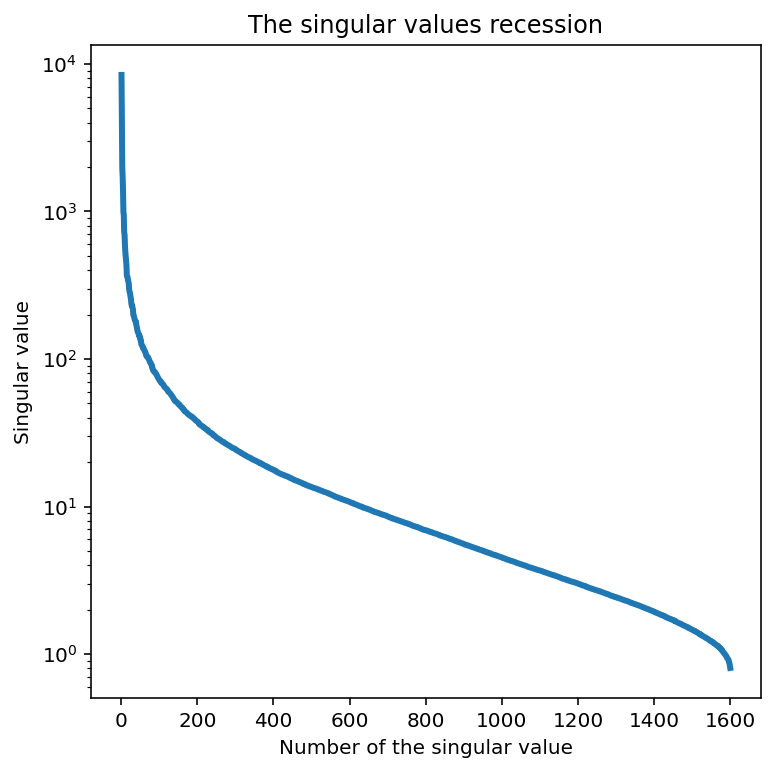

In [25]:
plt.semilogy(range(1, len(S) + 1), S, linewidth = 3)
plt.title('The singular values recession')
plt.xlabel('Number of the singular value')
plt.ylabel('Singular value')
plt.show()

<div class="alert alert-info">
We observe that singular values decrease monotonically and belong to the wide range from $\sim 10^4$ to $\sim 10^{-1}$. As the number of a singular value in the sequence of singular values increases, the slope of the curve becomes smoother.
</div>

* *Answer to the 2nd question:*

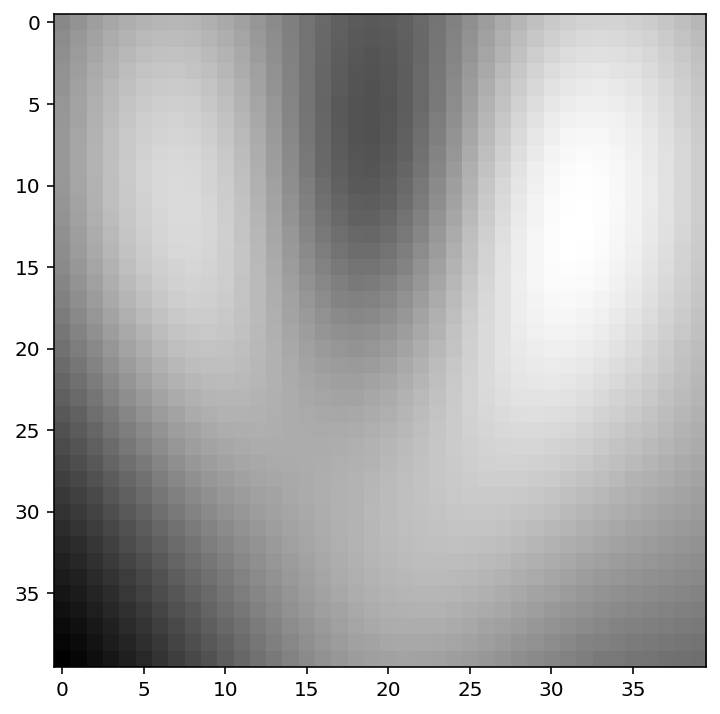

In [26]:
shadow2 = images['shadow2'].ravel()
image21 = TSVD_solver(U, S, Vt, shadow2, eps = 0.1).reshape((40, 40))
show(image21)

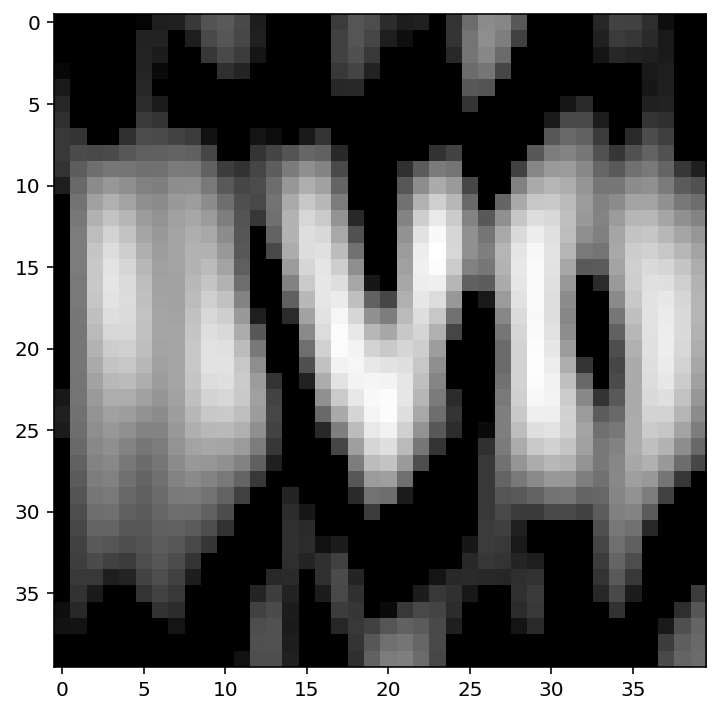

In [27]:
image22 = TSVD_solver(U, S, Vt, shadow2, eps = 0.01).reshape((40, 40))
show(image22)

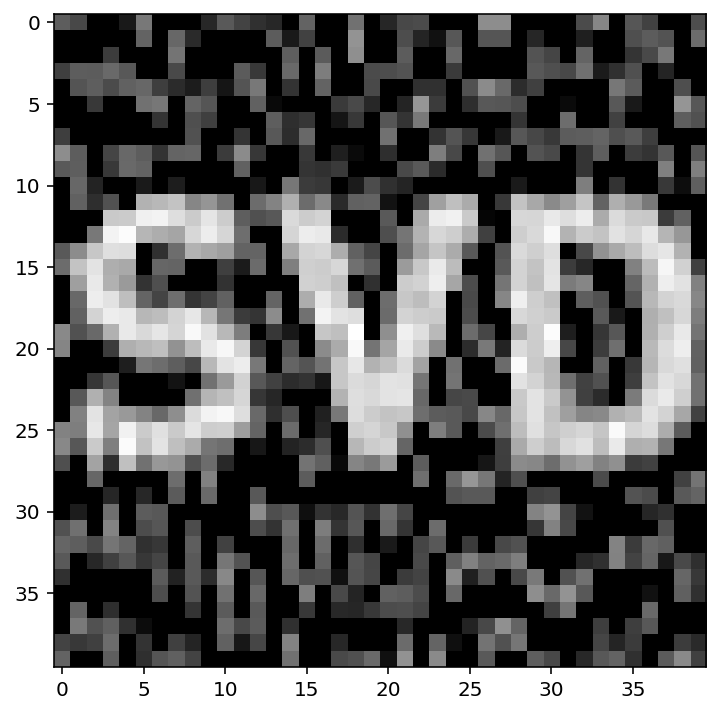

In [28]:
image23 = TSVD_solver(U, S, Vt, shadow2, eps = 0.001).reshape((40, 40))
show(image23)

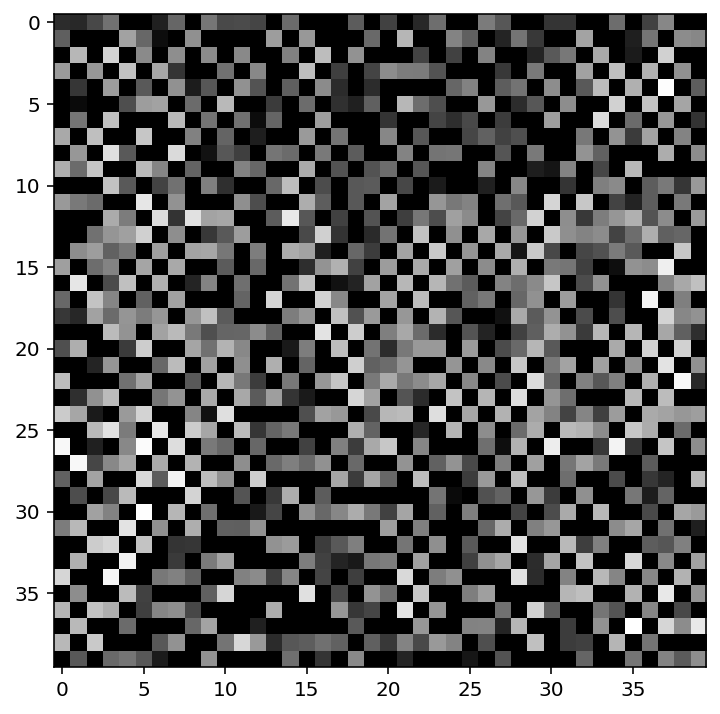

In [29]:
image24 = TSVD_solver(U, S, Vt, shadow2, eps = 10 ** (-100)).reshape((40, 40))
show(image24)

<div class="alert alert-info">
The shape of the light source is the abbreviation "SVD". We observe that for values $\epsilon = 0.1$ and $\epsilon = 0.01$ the shape of the light source isn't recognizable because we restrict the summation too early (we don't capture enough). At the same time, we see that the result for $\epsilon = 10^{-100}$ is also unrecognizable, because we restrict the summation late and get division by very small values of $\sigma_i$ that amplifies an error.
</div>

* *Answer to the 3rd question:*

Progress: 100.00%

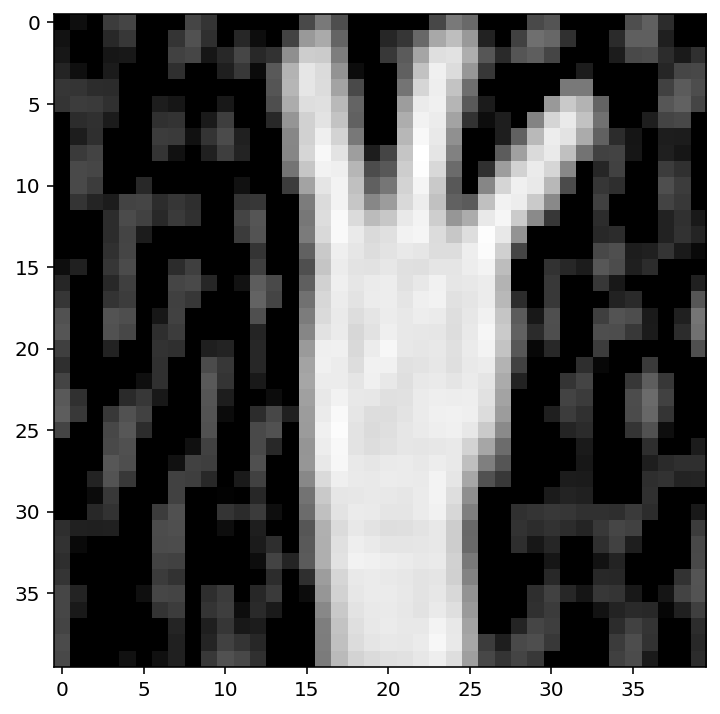

In [30]:
light_basis_qmark = render_basis(images['qmark'], 40)
U, S, Vt = la.svd(light_basis_qmark, full_matrices = False)

shadow3 = images['shadow3'].ravel()
image3 = TSVD_solver(U, S, Vt, shadow3, eps = 10 ** (-2.5)).reshape((40, 40))
show(image3)

<div class="alert alert-info">
The hand-shaped light source is holding up 3 fingers.
</div>

* *Answer to the 4th question:*

Progress: 100.00%

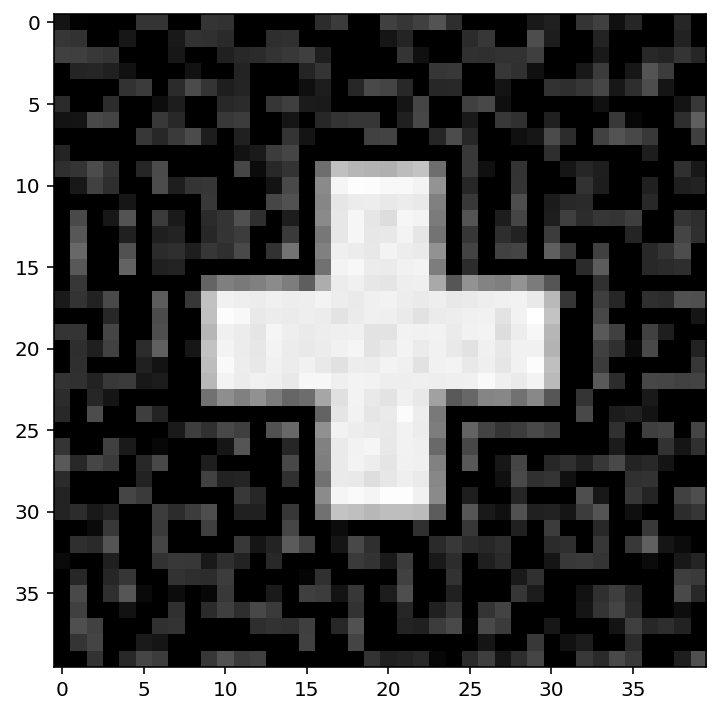

In [31]:
light_basis_decoupage = render_basis(images['decoupage'], 40)
U, S, Vt = la.svd(light_basis_decoupage, full_matrices = False)

shadow4 = images['shadow4'].ravel()
image4 = TSVD_solver(U, S, Vt, shadow4, eps = 10 ** (-2)).reshape((40, 40))
show(image4)

<div class="alert alert-info">
It looks like a white cross on a darker background. I may state that with a high degree of probability it is the Swiss flag.
</div>

Progress: 100.00%

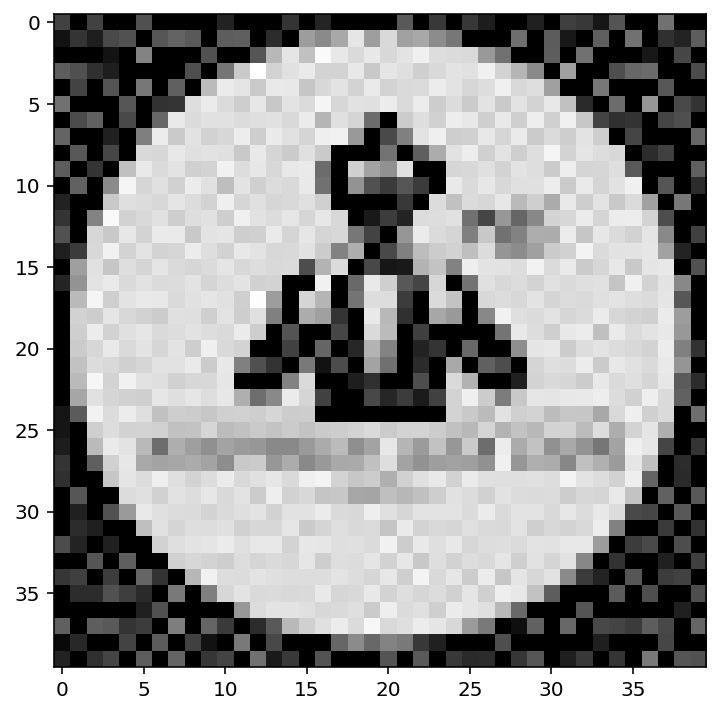

In [32]:
light_basis_epfl = render_basis(images['epfl'], 40)
U, S, Vt = la.svd(light_basis_epfl, full_matrices = False)

shadow5 = images['shadow5'].ravel()
image5 = TSVD_solver(U, S, Vt, shadow5, eps = 10 ** (-4)).reshape((40, 40))
show(image5)

<div class="alert alert-info">
The light source has a shape of "Montreux Jazz Café" logo.
</div>